<a href="https://colab.research.google.com/github/ayyucedemirbas/yolo_pytorch_object_detection/blob/main/yolo_pytorch_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9627, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 9627 (delta 69), reused 92 (delta 66), pack-reused 9531
Receiving objects: 100% (9627/9627), 9.95 MiB | 25.21 MiB/s, done.
Resolving deltas: 100% (6692/6692), done.


In [ ]:
!pip install -r yolov5/requirements.txt

     |████████████████████████████████| 636 kB 5.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
%mkdir Road_Sign_Dataset
%cd Road_Sign_Dataset

/content/Road_Sign_Dataset


In [ ]:
!wget -O RoadSignDetectionDataset.zip https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2

--2021-10-07 18:18:18--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 54.230.18.187
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|54.230.18.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229344361 (219M) [application/zip]
Saving to: ‘RoadSignDetectionDataset.zip’

RoadSignDetectionDa 100%[===================>] 218.72M  88.8MB/s    in 2.5s    

2021-10-07 18:18:21 (88.8 MB/s) - ‘RoadSignDetectionDataset.zip’ saved [229344361/229344361]



In [ ]:
!unzip RoadSignDetectionDataset.zip

In [ ]:
!rm -r RoadSignDetectionDataset.zip

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 4609.04it/s]


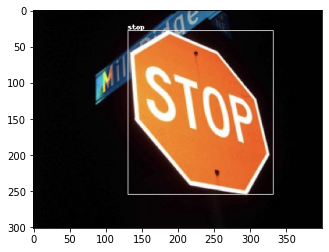

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
%mv annotations labels
%cd ../yolov5

/content/yolov5


In [ ]:
train= "../Road_Sign_Dataset/images/train/"
val=  "../Road_Sign_Dataset/images/val/"
test= "../Road_Sign_Dataset/images/test/"


In [ ]:
!wget -P data/ https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/road_sign_data.yaml

--2021-10-07 18:18:24--  https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/road_sign_data.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221 [text/plain]
Saving to: ‘data/road_sign_data.yaml’

road_sign_data.yaml 100%[===================>]     221  --.-KB/s    in 0s      

2021-10-07 18:18:25 (10.5 MB/s) - ‘data/road_sign_data.yaml’ saved [221/221]



In [ ]:
!ls -al data

total 68
drwxr-xr-x 5 root root 4096 Oct  7 18:18 .
drwxr-xr-x 7 root root 4096 Oct  7 18:17 ..
-rw-r--r-- 1 root root 2757 Oct  7 18:17 Argoverse.yaml
-rw-r--r-- 1 root root 1737 Oct  7 18:17 coco128.yaml
-rw-r--r-- 1 root root 2351 Oct  7 18:17 coco.yaml
-rw-r--r-- 1 root root 1886 Oct  7 18:17 GlobalWheat2020.yaml
drwxr-xr-x 2 root root 4096 Oct  7 18:17 hyps
drwxr-xr-x 2 root root 4096 Oct  7 18:17 images
-rw-r--r-- 1 root root 7320 Oct  7 18:17 Objects365.yaml
-rw-r--r-- 1 root root  221 Oct  7 18:18 road_sign_data.yaml
drwxr-xr-x 2 root root 4096 Oct  7 18:17 scripts
-rw-r--r-- 1 root root 2356 Oct  7 18:17 SKU-110K.yaml
-rw-r--r-- 1 root root 2927 Oct  7 18:17 VisDrone.yaml
-rw-r--r-- 1 root root 3381 Oct  7 18:17 VOC.yaml
-rw-r--r-- 1 root root 5033 Oct  7 18:17 xView.yaml


In [ ]:
!wget -P data/ https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/hyp.scratch.yaml

--2021-10-07 18:18:25--  https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/hyp.scratch.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1566 (1.5K) [text/plain]
Saving to: ‘data/hyp.scratch.yaml’

hyp.scratch.yaml    100%[===================>]   1.53K  --.-KB/s    in 0s      

2021-10-07 18:18:25 (22.2 MB/s) - ‘data/hyp.scratch.yaml’ saved [1566/1566]



In [ ]:
!wget -P data/ https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/yolov5s.yaml

--2021-10-07 18:18:25--  https://raw.githubusercontent.com/ayyucedemirbas/yolo_pytorch_object_detection/main/yolov5s.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1367 (1.3K) [text/plain]
Saving to: ‘data/yolov5s.yaml’

yolov5s.yaml        100%[===================>]   1.33K  --.-KB/s    in 0s      

2021-10-07 18:18:25 (71.7 MB/s) - ‘data/yolov5s.yaml’ saved [1367/1367]



In [ ]:
!ls -al

total 252
drwxr-xr-x 7 root root  4096 Oct  7 18:17 .
drwxr-xr-x 1 root root  4096 Oct  7 18:18 ..
-rw-r--r-- 1 root root  4970 Oct  7 18:17 CONTRIBUTING.md
drwxr-xr-x 5 root root  4096 Oct  7 18:18 data
-rw-r--r-- 1 root root 14916 Oct  7 18:17 detect.py
-rw-r--r-- 1 root root  1984 Oct  7 18:17 Dockerfile
-rw-r--r-- 1 root root  3672 Oct  7 18:17 .dockerignore
-rw-r--r-- 1 root root 16458 Oct  7 18:17 export.py
drwxr-xr-x 8 root root  4096 Oct  7 18:17 .git
-rw-r--r-- 1 root root    75 Oct  7 18:17 .gitattributes
drwxr-xr-x 4 root root  4096 Oct  7 18:17 .github
-rwxr-xr-x 1 root root  3892 Oct  7 18:17 .gitignore
-rw-r--r-- 1 root root  5733 Oct  7 18:17 hubconf.py
-rw-r--r-- 1 root root 35126 Oct  7 18:17 LICENSE
drwxr-xr-x 3 root root  4096 Oct  7 18:17 models
-rw-r--r-- 1 root root 14452 Oct  7 18:17 README.md
-rwxr-xr-x 1 root root   868 Oct  7 18:17 requirements.txt
-rw-r--r-- 1 root root 32005 Oct  7 18:17 train.py
-rw-r--r-- 1 root root 48722 Oct  7 18:17 tutorial.ipynb
drwxr

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

In [ ]:
!python train.py --img 640 --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=, data=road_sign_data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-496-g070af88 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, transla

In [ ]:
!python detect.py --source ../Road_Sign_Dataset/images/test/ --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['runs/train/yolo_road_det/weights/best.pt'], source=../Road_Sign_Dataset/images/test/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-496-g070af88 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
image 1/88 /content/Road_Sign_Dataset/images/test/road100.png: 640x640 1 speedlimit, Done. (0.035s)
image 2/88 /content/Road_Sign_Dataset/images/test/road113.png: 448x640 1 speedlimit, Done. (0.030s)
image 3/88 /content/Road_Sign_Dataset/images/test/road129.png: 448x640 1 trafficlight, 1 crosswalk, Done. (0.029s)
image 4/88 /content/Road_Sign_Dataset/images/test/road14

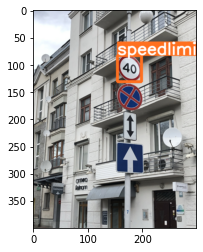

In [ ]:
detections_dir = "runs/detect/yolo_road_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!python val.py --weights runs/train/yolo_road_det/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

val: data=/content/yolov5/data/road_sign_data.yaml, weights=['runs/train/yolo_road_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False
YOLOv5 🚀 v5.0-496-g070af88 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning '../Road_Sign_Dataset/labels/test' images and labels...88 found, 0 missing, 0 empty, 0 corrupted: 100% 88/88 [00:00<00:00, 626.47it/s]
test: New cache created: ../Road_Sign_Dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:03<00:00,  1.32s/it]
                 all         88        126      0.971      0.943      0.946      0.779
        trafficlight         88         20    

In [ ]:
!zip -r yolo_road_det.zip runs/train/yolo_road_det

updating: runs/train/yolo_road_det/ (stored 0%)
updating: runs/train/yolo_road_det/results.csv (deflated 82%)
updating: runs/train/yolo_road_det/train_batch0.jpg (deflated 4%)
updating: runs/train/yolo_road_det/train_batch2.jpg (deflated 5%)
updating: runs/train/yolo_road_det/labels.jpg (deflated 23%)
updating: runs/train/yolo_road_det/hyp.yaml (deflated 44%)
updating: runs/train/yolo_road_det/events.out.tfevents.1633630711.523616ddecd1.161.0 (deflated 34%)
updating: runs/train/yolo_road_det/confusion_matrix.png (deflated 28%)
updating: runs/train/yolo_road_det/results.png (deflated 10%)
updating: runs/train/yolo_road_det/train_batch1.jpg (deflated 4%)
updating: runs/train/yolo_road_det/val_batch0_labels.jpg (deflated 13%)
updating: runs/train/yolo_road_det/weights/ (stored 0%)
updating: runs/train/yolo_road_det/weights/best.pt (deflated 8%)
updating: runs/train/yolo_road_det/weights/last.pt (deflated 8%)
updating: runs/train/yolo_road_det/R_curve.png (deflated 13%)
updating: runs/trai

In [ ]:
from google.colab import files
files.download("yolo_road_det.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>